<a href="https://colab.research.google.com/github/yuseungyeon/Tensorflow/blob/main/dp_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import easydict
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import linalg
from PIL import Image
from skimage import io, img_as_float, img_as_uint

image file

In [ ]:
# use Kaggle API to upload the dataset
!pip install kaggle

from google.colab import files
files.upload() # upload the token from kaggle.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yumamin","key":"c222b3a87ec28f9929fe1f4c5e055e41"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Make a directory named kaggle and copy the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 806M/814M [00:06<00:00, 119MB/s]
100% 814M/814M [00:06<00:00, 136MB/s]


In [ ]:
from zipfile import ZipFile
import os
folder = '/content'
extension ='.zip'
for item in os.listdir(folder):
  if item.endswith(extension):
    with ZipFile(item, 'r') as zip:
      zip.extractall()
print('Done')

Done


In [ ]:
folder = '/content'
extension ='.zip'
for item in os.listdir(folder):
  if item.endswith(extension):
    if item == "/content/dogs-vs-cats-redux-kernels-edition.zip":
      pass
    else:
      with ZipFile(item, 'r') as zip:
        zip.extractall()

In [ ]:
import shutil
!mkdir ./train/dog
!mkdir ./train/cat

folder_path = '/content/train'
training_dog_dir = '/content/train/dog'
training_cat_dir = '/content/train/cat'

for item in os.listdir(folder_path):
  if item.startswith("dog."):
    shutil.move(folder_path+'/'+item, training_dog_dir)
  elif item.startswith("cat."):
    shutil.move(folder_path+'/'+item, training_cat_dir)

print("Transfer Completed")

Transfer Completed


In [ ]:
import os
import random
import numpy as np
from PIL import Image

In [ ]:
def pillow_to_numpy(I):
    img = np.asarray(I, dtype=np.float32)
    return img

def numpy_to_pillow(img):
    I = Image.fromarray(img.astype(np.uint8))
    return I

In [ ]:
def display_image_grid(images, size=(12,12), titles=None, num_cols=4):
    images = list(map(numpy_to_pillow, images))
    fig = plt.figure(figsize=size)
    fig.tight_layout(pad=0)
    N = len(images)
    cols = num_cols
    rows = N/cols if N%cols == 0 else (N//cols + 1)
    for i in range(N):
        ax = fig.add_subplot(rows, cols, i+1)
        plt.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        if titles is not None:
            ax.set_title(titles[i])

In [ ]:
def load(dataset, n = 16):
  images = dataset.load_images(n)
  display_image_grid(images)
  return images

In [ ]:
def choose_random_path(path):
    files = os.listdir(path)
    file = random.choice(files)
    path = os.path.join(path, file)
    return path

class Dataset:
    def __init__(self):
        self.data_dir = ''
        self.scale = None

    def get_random_image():
        pass

    def load_images(self, n=16):
        image_paths = set([self.get_random_image() for i in range(n)])
        images = list(map(pillow_to_numpy, map(Image.open, image_paths)))
        return images

class AnimalDataset(Dataset):
    def __init__(self):
        self.data_dir = "/content/train/cat"
        self.scale = (300,300)

    def get_random_image(self):
        image = choose_random_path(self.data_dir)
        #image = choose_random_path(animal)
        return image

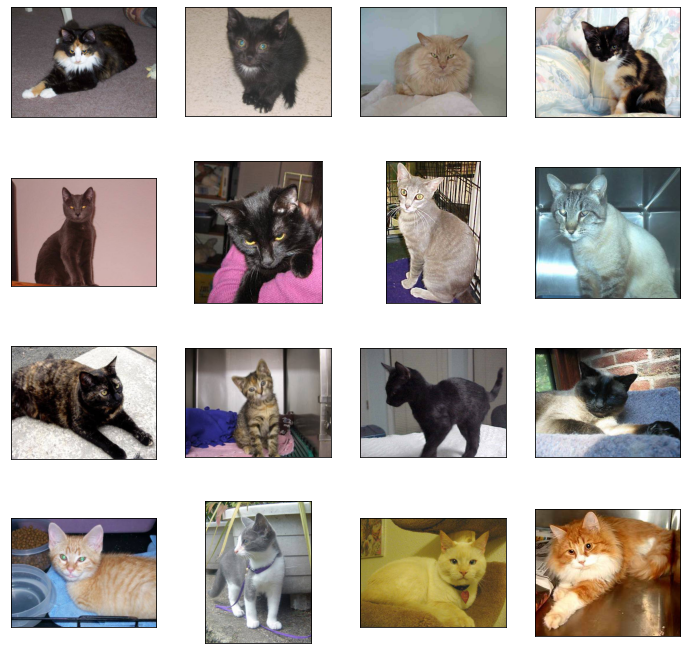

In [ ]:
animal = load(AnimalDataset())

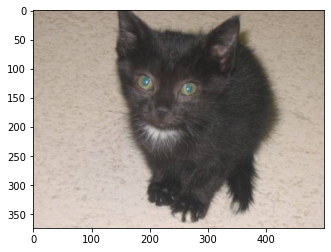

In [ ]:
plt.imshow(list(map(numpy_to_pillow, animal))[1])

In [ ]:
import numpy as np
import pandas as pd
from numpy.linalg import svd
from scipy.special import factorial
import sympy as sp
import copy as cp
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def dk_privacy_l2(ori_img,  epsilon):
  return np.sqrt(np.square(ori_img)).sum(axis = 0)/epsilon

In [ ]:
def dk_privacy(ori_img, k, epsilon):
  sampling_1 = 1/2 * np.power(epsilon/np.sqrt(np.pi),k) * factorial(k/2-1)/factorial(k-1) * np.exp(-epsilon * np.sqrt(np.square(ori_img)).sum(axis = 0))
  while True:
    derivative = dk_privacy_l2(sampling_1, epsilon)
    sampling_1 -= derivative
    if derivative <= 1e-10:
      break
  return sampling_1

In [ ]:
def getRandomSamplesOnNSphere(N , R , numberOfSamples):
    # Return 'numberOfSamples' samples of vectors of dimension N
    # with an uniform distribution on the (N-1)-Sphere surface of radius R.
    # RATIONALE: https://mathworld.wolfram.com/HyperspherePointPicking.html

    X = np.random.default_rng().normal(size=(numberOfSamples , N))

    return R / np.sqrt(np.sum(X**2, 1, keepdims=True)) * X

In [ ]:
def trans_privacy(ori_img, k, psilon):
  ind = np.argpartition(ori_img, -k)[-k:]
  top_k = ori_img[ind]
  trans_vec = dk_privacy(top_k, k, epsilon)
  radial = getRandomSamplesOnNSphere(k, trans_vec, 1)
  result_vec = top_k +  radial * trans_vec
  trans_img = np.zeros_like(ori_img)
  trans_img[ind] = result_vec
  return trans_img

In [ ]:
def img_svd(img, k, epsilon):
  red, green, blue = cp.deepcopy(img[:,:,0]), cp.deepcopy(img[:,:,1]), cp.deepcopy(img[:,:,2])

  U_red, S_red, V_red = svd(red, full_matrices = False)
  U_green, S_green, V_green  = svd(green, full_matrices = False)
  U_blue, S_blue, V_blue = svd(blue, full_matrices = False)

  trans_red = trans_privacy(S_red, k, epsilon)
  trans_green = trans_privacy(S_green, k, epsilon)
  trans_blue = trans_privacy(S_blue, k, epsilon)

  final_red = U_red @ (np.diag(trans_red) @ V_red)
  final_green = U_green @ (np.diag(trans_green) @ V_green)
  final_blue = U_blue @ (np.diag(trans_blue) @ V_blue)


  fimg = np.zeros(img.shape)

  fimg[:,:,0], fimg[:,:,1], fimg[:,:,2] = final_red, final_green, final_blue

  for i in range(len(fimg)):
    for j in range(len(fimg[i])):
      for w in range(len(fimg[i][j])):
        fimg[i,j,w] = min(255, abs(fimg[i,j,w]))

  fimg = fimg.astype(np.uint8)
  return fimg

In [ ]:
def dp_svd(images, k, epsilon):
  noisy_images = [img_svd(I, k, epsilon) for I in images]
  display_image_grid(noisy_images)

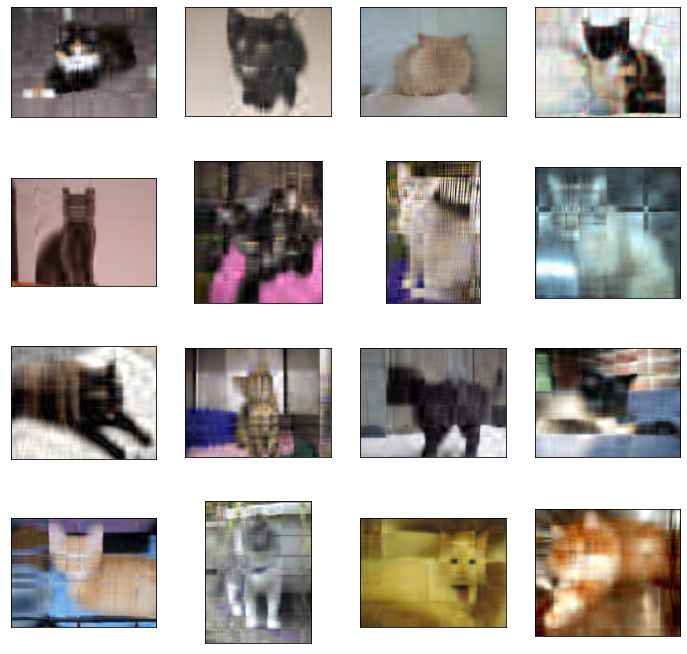

In [ ]:
k = 7
epsilon = 0.01

dp_svd(animal, k, epsilon)

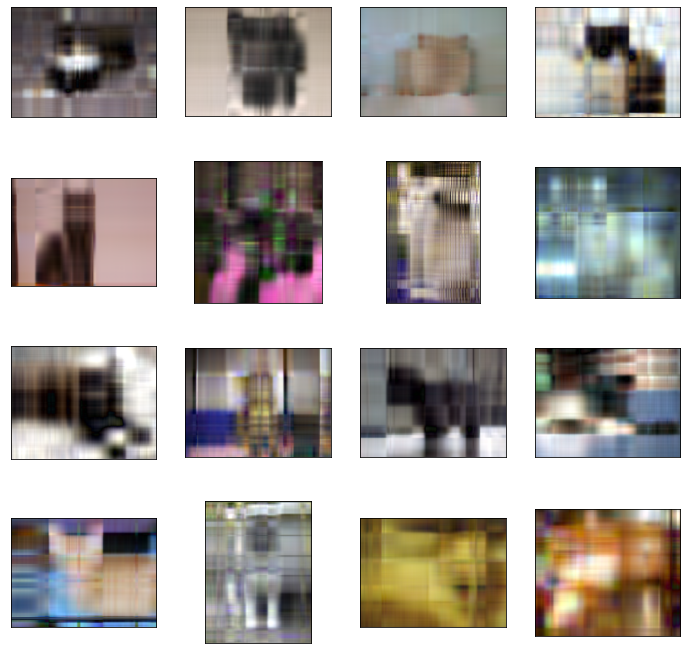

In [ ]:
k = 4
epsilon = 1

dp_svd(animal, k, epsilon)

In [ ]:
def original_img_svd(img, k):
  red, green, blue = cp.deepcopy(img[:,:,0]), cp.deepcopy(img[:,:,1]), cp.deepcopy(img[:,:,2])

  U_red, S_red, V_red = svd(red, full_matrices = False)
  U_green, S_green, V_green  = svd(green, full_matrices = False)
  U_blue, S_blue, V_blue = svd(blue, full_matrices = False)

  final_red = U_red[:,:k] @ (np.diag(S_red[:k]) @ V_red[:k,:])
  final_green = U_green[:,:k] @ (np.diag(S_green[:k]) @ V_green[:k,:])
  final_blue = U_blue[:,:k] @ (np.diag(S_blue[:k]) @ V_blue[:k,:])


  fimg = np.zeros(img.shape)

  fimg[:,:,0], fimg[:,:,1], fimg[:,:,2] = final_red, final_green, final_blue

  for i in range(len(fimg)):
    for j in range(len(fimg[i])):
      for w in range(len(fimg[i][j])):
        fimg[i,j,w] = min(255, abs(fimg[i,j,w]))

  fimg = fimg.astype(np.uint8)
  return fimg

In [ ]:
def original_svd(images, k):
  noisy_images = [original_img_svd(I, k) for I in images]
  display_image_grid(noisy_images)

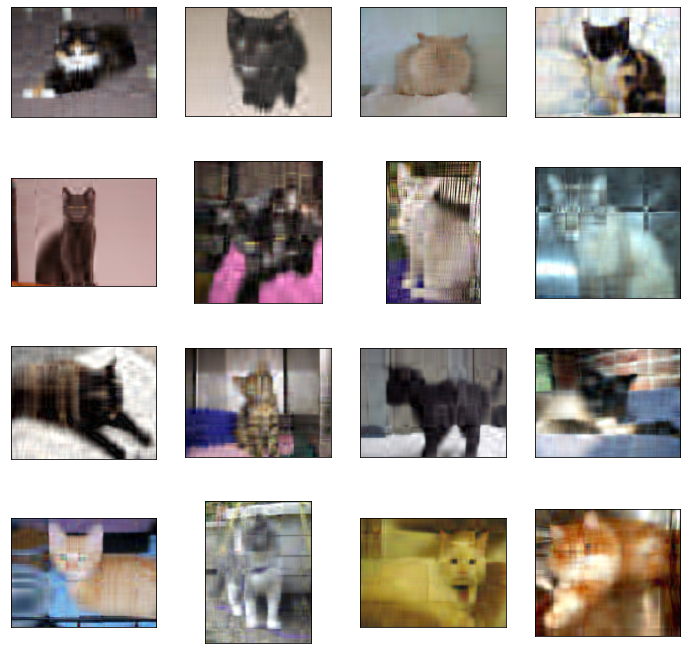

In [ ]:
k = 8

original_svd(animal, k)